## Goal

This module will dive into Streaming, and building on memory.

### Learning Steps:
- `Streaming`

#### Standard imports

In [1]:
from typing import TypedDict, Annotated, Literal

from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, RemoveMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool

from langgraph.graph import START, END, StateGraph, add_messages, MessagesState, MessageGraph
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import display, Image

In [2]:
load_dotenv()

True

In [3]:
llm = ChatOpenAI(model="gpt-4o")

In [4]:
'''
MessageState by default give messages as a key and adds "add_messages" automatically and includes TypedDict
So, its a dictionary of list
e.g.
messages: list[AnyMessages]
summary: str
'''
class State(MessagesState):
    summary: str

In [5]:
def call_model(state: State):
    summary = state.get("summary","")

    if summary:
        system_message =  f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = llm.invoke(messages)
    return {"messages": [response]}

In [6]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]] ## its a list
    return {"summary": response.content, "messages": delete_messages}

In [14]:
# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal ["summarize_conversation",END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 4:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

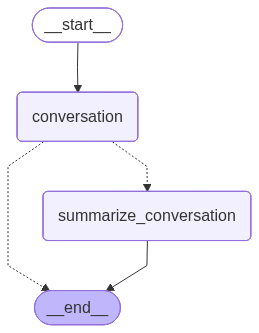

In [15]:
# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

if "summary" in output:
    print("\n--- Updated Summary ---")
    print(output["summary"])

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

if "summary" in output:
    print("\n--- Updated Summary ---")
    print(output["summary"])

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

if "summary" in output:
    print("\n--- Updated Summary ---")
    print(output["summary"])

================================== Ai Message ==================================

Hello Lance! How can I assist you today?
================================== Ai Message ==================================

You mentioned that your name is Lance. How can I assist you further?
================================== Ai Message ==================================

That's great! The San Francisco 49ers have a rich history and a strong fan base. Do you have a favorite player or a memorable game that you enjoyed watching?

--- Updated Summary ---
Lance introduced himself and mentioned that he likes the San Francisco 49ers. The assistant acknowledged his name and his interest in the 49ers, and asked if he had a favorite player or memorable game.


In [17]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

if "summary" in output:
    print("\n--- Updated Summary ---")
    print(output["summary"])

================================== Ai Message ==================================

Yes, Nick Bosa became one of the highest-paid defensive players in NFL history. In September 2023, he signed a contract extension with the San Francisco 49ers, making him the highest-paid defensive player at that time. Bosa's impact on the field is significant, and he's a key player for the team's defense. Are there any particular games or moments of his that stand out to you?

--- Updated Summary ---
Lance introduced himself and mentioned that he likes the San Francisco 49ers. The assistant acknowledged his name and his interest in the 49ers, and asked if he had a favorite player or memorable game.


In [18]:
graph.get_state(config).values.get("summary","")

'Lance introduced himself and mentioned that he likes the San Francisco 49ers. The assistant acknowledged his name and his interest in the 49ers, and asked if he had a favorite player or memorable game.'

## Streaming
- `graph.stream()` yields partial state updates as a generator.
- `stream_mode="updates"`: LangGraph yields incremental state updates — i.e., only the parts of the graph state that have changed since the previous chunk.
-  `stream_mode="values"`: LangGraph yields the entire state value after each node completes, not just the updates.

In [28]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Lance")]}, config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': [AIMessage(content="Hello, Lance! I'm here to chat if there's anything you'd like to talk about or any questions you have. Just let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 201, 'total_tokens': 228, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CRESJp9UqfkTM2tb9Dbeb8qsAiZHT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--d4a87ff4-a627-4c93-baf5-9abe7b72d790-0', usage_metadata={'input_tokens': 201, 'output_tokens': 27, 'total_tokens': 228, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}
{'summarize_conversation': {'summary': 'In this

In [31]:
# Start conversation
for chunk in graph.stream(
    {"messages": [HumanMessage(content="hi! I'm Lance")]}, 
    config, 
    stream_mode="updates"
):
    for m in chunk['conversation']["messages"]:
        m.pretty_print()

================================== Ai Message ==================================

Hi Lance! Great to hear from you again. Whenever you're ready to dive into a topic or have any questions, feel free to share!


#### `astream_events()`

Normally, `graph.invoke()` or `graph.stream()` only give you final states (like “messages,” “summary,” etc.) or partial state updates between nodes.

But under the hood, there’s much more happening:
- Each node in your LangGraph may invoke an LLM call,
- The LLM call itself streams tokens as they’re generated,
- LangGraph tracks internal node start/end events, message updates, and errors.

👉 `graph.astream_events()` lets you tap into that entire event stream, so you can observe what’s happening inside the graph, in real time, token by token or node by node.

| Use Case                      | Benefit                                                                         |
| ----------------------------- | ------------------------------------------------------------------------------- |
| **Real-time token streaming** | You can print each token as the LLM generates it (like OpenAI’s streaming API). |
| **Tracing / Debugging**       | You can see when each node starts and ends, and what data it emits.             |
| **Building interactive UIs**  | Perfect for updating chat bubbles, progress indicators, or dashboards live.     |
| **Profiling**                 | You can measure latency between node starts/ends.                               |


| Event Type             | Description                              | Common Use                                  |
| ---------------------- | ---------------------------------------- | ------------------------------------------- |
| `on_chat_model_start`  | When a Chat Model node (LLM call) begins | Start timing, allocate log record           |
| `on_chat_model_stream` | When partial tokens are streamed back    | Real-time token streaming (✅ the juicy one) |
| `on_chat_model_end`    | When the LLM finishes                    | Close stream, compute latency               |
| `on_tool_start`        | When a tool/function node begins         | Debug tool call latency                     |
| `on_tool_end`          | When tool execution completes            | Get result, log                             |
| `on_node_end`          | When a graph node finishes               | Update UI or save intermediate state        |
| `on_graph_end`         | When the entire graph finishes           | Final output ready                          |


In [33]:
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")

async for event in graph.astream_events(
    {"messages": [input_message]}, 
    config, 
    version="v2"
):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. N

In [34]:
node_to_stream = 'conversation'
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--32f3ce34-3dbe-465d-a42e-c9988dbb029f')}
{'chunk': AIMessageChunk(content='The', additional_kwargs={}, response_metadata={}, id='run--32f3ce34-3dbe-465d-a42e-c9988dbb029f')}
{'chunk': AIMessageChunk(content=' San', additional_kwargs={}, response_metadata={}, id='run--32f3ce34-3dbe-465d-a42e-c9988dbb029f')}
{'chunk': AIMessageChunk(content=' Francisco', additional_kwargs={}, response_metadata={}, id='run--32f3ce34-3dbe-465d-a42e-c9988dbb029f')}
{'chunk': AIMessageChunk(content=' ', additional_kwargs={}, response_metadata={}, id='run--32f3ce34-3dbe-465d-a42e-c9988dbb029f')}
{'chunk': AIMessageChunk(content='49', additional_kwargs={}, response_metadata={}, id='run--32f3ce34-3dbe-465d-a42e-c9988dbb029f')}
{'chunk': AIMessageChunk(content='ers', additional_kwargs={}, response_metadata={}, id='run--32f3ce34-3dbe-465d-a42e-c9988dbb029f')}
{'chunk': AIMessageChunk(content=',', additional_kwargs={}, respons

In [35]:
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Tell me about the 49ers NFL team")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node 
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|The| San| Francisco| |49|ers| are| a| professional| NFL| team| located| in| the| San| Francisco| Bay| Area|.| They| were| founded| in| |194|6| and| joined| the| NFL| in| |194|9| following| the| merger| with| the| All|-Amer|ica| Football| Conference|.| The| team| plays| its| home| games| at| Levi|'s| Stadium| in| Santa| Clara|,| California|.

|The| |49|ers| are| renowned| for| their| success| during| the| |198|0|s| and| |199|0|s|,| securing| five| Super| Bowl| championships| in| the| |198|1|,| |198|4|,| |198|8|,| |198|9|,| and| |199|4| seasons|.| This| era| featured| legendary| figures| like| Joe| Montana|,| Jerry| Rice|,| and| Steve| Young|,| all| of| whom| have| left| a| lasting| legacy| on| the| team| and| the| sport|.

|Bill| Walsh|,| the| team's| head| coach| during| much| of| its| successful| period|,| introduced| the| West| Coast| offense|,| a| strategic| approach| that| revolution|ized| the| game|.| The| franchise|'s| stor|ied| history|,| passionate| "|N|iner| Empire|"| fan| ba